# **AlTar 2 - a toy model with epistemic uncertainties**

# **Step 1 - prepare the input files**
---
### Understand the example: what do we want to do?

We consider a simple 2.5 dimensional model of a strike-slip fault that extends infinitely along strike. Strike-perpendicular and vertical directions are respectively defined by the $\mathbf{x}_1$ and $\mathbf{x}_2$ axes, the free surface being the $(\mathbf{x}_1$, $\mathbf{x}_3)$ plane (see Figure 1). The displacement on the fault is restricted to the $\mathbf{x}_3$ direction (i.e., along strike direction). Each surface displacement is calculated for a particular data point located at $x_1$ along the strike-perpendicular direction $\mathbf{x}_1$ (and then for $x_2 = 0$).

![Figure 1. ](intro_cp_fig.png)

The aim of this example is to provide the **AlTar** input and configuration files to solve for a synthetic test which includes epistemic uncertainties. The synthetic observations will be calculated for a heterogeneous medium, in which the fault bounds two media of different shear moduli. The assumed Green's functions will be calculated in an homogeneous half space, thus inducing epistemic uncertainties in the inverse problem (because the assumed medium does not correspond to the one used to calculate the synthetic data). We will thus calculate the corresponding prediction covariance matrix $\mathbf{C}_\mathrm{p}$ to account for these epistemic uncertainties.

In this example, we will:
- Run through the calculation of a synthetic dataset, using analytical expressions
- Calculate the Green's functions from analytical expressions, either for a homogeneous half space or for a heterogeneous medium.
- Calculate the sensitivity kernels of the Green's functions from analytical expressions, and calculate the prediction covariance matrix

The content is organized as follow:
1. Setup of the Toy Model
2. Calculate data and uncertainties for an heterogeneous medium
    1. Calculate the data from analytical expressions
    2. Calculate the data covariance matrix
    3. Plot the data
3. Calculate the Green's functions
    1. Heterogeneous Green's functions
    2. Homoegeneous Green's functions
    3. Compare Homogeneous and heterogeneous Green's functions
    4. Investigate the impact of the shear moduli ratio on Green's functions
4. Calculate the Prediction Covariance Matrix
    1. Calculate the seinsitivity kernels
    2. Setup the covariance of the shear moduli and the initial slip model
    3. Calculate the misfit covariance matrix
5. Export **Altar** input files
6. Write the `.pfg` configuration file for use with GPUs

If you're not interested in the calculation of the synthetic dataset and Green's functions, you can jump directly to the sections where $\mathbf{C}_\mathrm{p}$, or where the **AlTar** configuration file is written.

> *Note: if you have any troubles understanding the concepts presented here, please refer to the **Altar** User Guide.*

> ***Note2: you can use [nbviewer](https://nbviewer.jupyter.org/) to interactively play with this notebook***


### 1. Setup of the Toy Model

We begin by importing the necessary modules

In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import seaborn as sns
import h5py
import scipy
import collections as col
import mpmath

Then, we can define a name for our future test:

In [2]:
name = 'test1'

Let's define the parameters of the fault geometry we will assume. These parameters are:

In [3]:
length = 500000. # in km. The length is very long
width = 10000.  # in km. The width of a vertical fault is the depth it reaches.
nstrike = 1.  # subfault along strike
ndip = 20  # subfaults along dip. Each subfault is thus of 500 m x 250 km
strike = 0  # in degrees. It does not matter here
dip = 90.  # in degrees. We want a vertical fault

Np = int(ndip*nstrike*2)  # Np is the number of parameters of the model

The parameters of the crustal structure are:

In [4]:
mu1 = 2.0  # shear modulus on the West side of the fault
mu2 = 5.0  # on the right side

And the slip will be uniform on the fault, with no slip along dip. The slip along strike is:

In [5]:
s = 10.0  # in m.
d = width  # the slip is equall to s from 0 to depth d

### 2. Calculate data and uncertainties for an heterogeneous medium

#### 2.1 Calculate the data from analytical expressions

Now, we want to define our data points `x`, which will be equally distributed along a line perpendicular to the fault direction (along the $\mathbf{x}_1$ axis).

In [6]:
x = np.linspace(-40000,40000,100)


Following Segall (2010), we can derive the expression of the surface displacement produced by an infinitely long vertical strike-slip fault bounding two media of different shear modulus, $\mu_1$ and $\mu_2$. The slip $s$ on the fault extends from the free surface to depth $d$. We will refer to displacement $u^{(1)}$ on the side with modulus $\mu_1$, and to displacement $u^{(2)}$ on the side with modulus $\mu_2$.
\begin{equation}
\begin{split}
u^{(1)}\left(x_{1},  x_{2}=0\right)=   \frac{2 s}{\pi} \; \frac{\mu_2}{\mu_1 + \mu_2} \; \tan^{-1} \biggr( \frac{d}{x_{1}} \biggr) \\
u^{(2)}\left(x_{1},  x_{2}=0\right)=   \frac{2 s}{\pi} \; \frac{\mu_1}{\mu_1 + \mu_2} \; \tan^{-1} \biggr( \frac{d}{x_{1}} \biggr)
\end{split}
\end{equation}

Note that the displacement is along $\mathbf{x}_3$, is calculated at the free surface (so with $\mathbf{x}_2$=0), and only depends on $\mathbf{x}_1, the strike perpendicular direction.

We can create a function to calculate the surface displacement follwing this expression, for a particular data point `x_i`:

In [7]:
def calcSurfaceDispHet(x_i, s, d, mu1, mu2):
    '''
    Returns the surface displacement in meters.
    '''
    if x_i < 0:
        u = ((2*s) / np.pi) * (mu2 / (mu1 + mu2)) * np.arctan(d / x_i)
    else:
        u = ((2*s) / np.pi) * (mu2 / (mu1 + mu2)) * np.arctan(d / x_i)
    return float(u)

Now, we are able to calculate the surface displacement associated with the slip `s` at every data point.

In [8]:
u_x3 = []
for i in range(len(x)):
    if x[i] == 0:
        u_x3.append(0)
    else:
        u_x3.append( calcSurfaceDispHet(x[i], s, d, mu1, mu2) )

We can also add noise to our data. We assume the noise to be approximately 2% of the maximum surface displacement.


In [9]:
noise_amplitude = 0.02 * np.amax(u_x3)
print("noise amplitude (cm): ", noise_amplitude*100)

noise_type = 'no'

if noise_type is 'uncorrelated':
    noise = noise_amplitude*np.random.normal(0,1,len(u_x3))
elif noise_type is 'correlated':
    #### NOT SURE VERIFY
    A = np.zeros((len(u_x3), len(u_x3)))
    cov = [ [math.exp(- abs(i - j) / 200.) for i in range(len(u_x3))] for j in range(len(u_x3))]
    w, v = np.linalg.eig(cov)
    for i in range(len(u_x3)):
        for j in range(len(u_x3)):
            A[i, j] = sum(math.sqrt(w[k]) * v[i, k] * v[j, k] for k in range(len(u_x3)))
    x2 = 0.5 * noise_amplitude * np.random.normal(0, 1, len(u_x3))
    noiseuncorr = 0.5 * noise_amplitude * np.random.normal(0, 1, len(u_x3))
    noise = np.dot(A, x2) + noiseuncorr
elif noise_type is 'no':
    noise = np.zeros(np.shape(u_x3))
else:
    print("Please define noise_type")

u_x3 += noise

noise amplitude (cm):  13.918456746377112


As input for **AlTar**, we also need to define the surface displacement along the axes $\mathbf{x}_1$ (East) and $\mathbf{x}_2$ (Up).


In [10]:
u_x1 = np.zeros(np.shape(u_x3))
u_x2 = np.zeros(np.shape(u_x3))

And we prepare for use with **Altar** a vector `u` witch containes the displacements along East direction, along North, and the Vertical displacements.

In [11]:
u = np.concatenate( (u_x1, u_x3, u_x2), axis=0 )
print("Number of data: ",len(u))

Number of data:  300


#### 2.2 Calculate the data covariance matrix $\mathbf{C}_\mathrm{d}$

In this simple case, we assume that there is no covariance between the data points, and that their variance is uniform.

In [12]:
var_u = (0.05 * np.amax(u_x3))**2
Cd = np.diag( var_u * np.ones(np.shape(u)) )

#### 2.3 Plot the data

Let's plot the calculated surface displacement and its uncertainties in fonction of the distance from the fault:

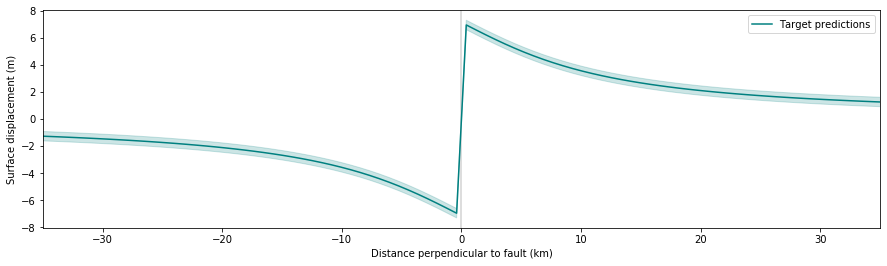

In [13]:
fig=plt.figure(figsize=(15,4))
plt.axvline(x=0,color='lightgray')
plt.fill_between(x/1000, u_x3 - np.sqrt(var_u), u_x3 + np.sqrt(var_u),color='teal', alpha=0.2)
plt.plot(x/1000, u_x3,color='teal',label='Target predictions')
plt.xlim([-35,35])
plt.xlabel('Distance perpendicular to fault (km)')
plt.ylabel('Surface displacement (m)')
plt.legend()
plt.show()

### 3. Calculate the Green's functions

#### 3.1 Heterogeneous Green's functions

From the expressions of the surface displacement presented above, we can derive the expression of the Green's functions and their derivatives. The Green's functions are the surface displacement induced by a unit slip on one subfault. We will consider a subfault $f_i$ of width $\delta d = d_{i+1} - d_i$, $d_{i+1} \ge d_i$. The Green's function $G(x_j, f_i)$ can be expressed as the difference between the surface displacement due to a finite dislocation between the free surface and depth $d_{i+1}$, and another finite dislocation between the free surface and depth $d_{i}$.

For an infinitely long vertical strike-slip fault bounding two media of different shear modulus, $\mu_1$ and $\mu_2$, we thus have:

\begin{equation}
\begin{split}
\mathbf{G}_v^{(1)}(x_j, f_i)  = u_v^{(1)}(x_{j}, d_{i+1}) - u_v^{(1)}(x_{j}, d_{i}) \\
\mathbf{G}_v^{(2)}(x_j, f_i)  = u_v^{(2)}(x_{j}, d_{i+1}) - u_v^{(2)}(x_{j}, d_{i})
\end{split}
\end{equation}	

\begin{equation}
\begin{split}
\mathbf{G}_v^{(1)}(x_j, f_i) = \frac{2}{\pi} \; \frac{\mu_2}{\mu_1 + \mu_2} \; \biggr[ \tan^{-1} \biggr( \frac{d_{i+1}}{x_{j}} \biggr) - \tan^{-1} \biggr( \frac{d_{i}}{x_{j}} \biggr) \biggr] \\
\mathbf{G}_v^{(2)}(x_j, f_i) = \frac{2}{\pi} \; \frac{\mu_1}{\mu_1 + \mu_2} \; \biggr[ \tan^{-1} \biggr( \frac{d_{i+1}}{x_{j}} \biggr) - \tan^{-1} \biggr( \frac{d_{i}}{x_{j}} \biggr) \biggr] 
\end{split}
\end{equation}	

In [14]:
def calcGFhet(x, mu1, mu2, width, ndip):
    '''
    Returns the GFs in meters
    '''
    d = np.linspace(0.,width,ndip+1)
    G1 = np.zeros((len(x)//2,len(d)-1))
    G2 = np.zeros((len(x)//2,len(d)-1))
    for j in range(len(x)//2):
        for i in range(0,len(d)-1):
            G1[j,i] = (2/np.pi) *  (mu2/(mu1+mu2)) * ( mpmath.atan(d[i+1]/x[j]) - mpmath.atan(d[i]/x[j]) )
    for j in range(len(x)//2,len(x)):
        for i in range(0,len(d)-1):
            G2[j-len(x)//2,i] = (2/np.pi) *  (mu1/(mu1+mu2)) * ( mpmath.atan(d[i+1]/x[j]) - mpmath.atan(d[i]/x[j]) )
    Gv = np.vstack((G1,G2))
    return Gv

## For the strike-slip component and the x3 (North) direction:
Gv_ss_x3 = calcGFhet(x, mu1, mu2, width, ndip)

## For the strike-slip component and the other directions:
Gv_ss_x1 = np.zeros( np.shape(Gv_ss_x3) )
Gv_ss_x2 = np.zeros( np.shape(Gv_ss_x3) )

## Full GFs for the strike-slip direction
Gv_ss = np.concatenate( (Gv_ss_x1, Gv_ss_x3, Gv_ss_x2), axis = 0)

## dip-slip direction:
Gv_ds = np.zeros( np.shape(Gv_ss) )

## Full GFs
Gv = np.concatenate( (Gv_ss, Gv_ds), axis = 0)

#### 3.2 Homogeneous Green's Functions

As for the heterogeneous case, the expression of the surface displacement for an infinite strike slip fault breaking the surface and embedded in a homogeneous half space is (Segall, 2010):
\begin{equation}
u_h(x_2=0) = - \frac{s}{\pi} \tan^{-1} \left( \frac{x}{x_1} \right)
\end{equation}

> *Note that this displacement is similar to the heterogeneous case for $\mu_1 = \mu_2$.*

We can then derive the expression of the Green's Functions:
\begin{equation}
\mathbf{G}_h(x_j, f_i) = \frac{2}{\pi} \; \biggr[ \tan^{-1} \biggr( \frac{d_{i+1}}{x_{j}} \biggr) - \tan^{-1} \biggr( \frac{d_{i}}{x_{j}} \biggr) \biggr] \\
\end{equation}	

In [15]:
def calcGFhom(x, width, ndip):
    '''
    Returns the GFs in meters
    '''
    d = np.linspace(0.,width,ndip+1)
    Gh = np.zeros((len(x),len(d)-1))
    for j in range(len(x)):
        for i in range(0,len(d)-1):
            Gh[j,i] = (1/np.pi) *  ( mpmath.atan(d[i+1]/x[j]) - mpmath.atan(d[i]/x[j]) )
    return Gh

In [16]:
## For the strike-slip component and the x3 (North) direction, homogeneous case:
Gh_ss_x3 = calcGFhom(x, width, ndip)

## And similarly to the previous case:
Gh_ss_x1 = np.zeros( np.shape(Gh_ss_x3) )
Gh_ss_x2 = np.zeros( np.shape(Gh_ss_x3) )
Gh_ss = np.concatenate( (Gh_ss_x1, Gh_ss_x3, Gh_ss_x2), axis = 0)
Gh_ds = np.zeros( np.shape(Gh_ss) )
Gh = np.concatenate( (Gh_ss, Gh_ds), axis = 0)

#### 3.3 Compare the homogeneous and heterogeneous Green's functions:

For the shallowest and the deepest sub-faults, we compare the homogeneous and heterogeneous Green's functions (we thus compare the surface displacement induced by a unit slip on each of these subfaults):

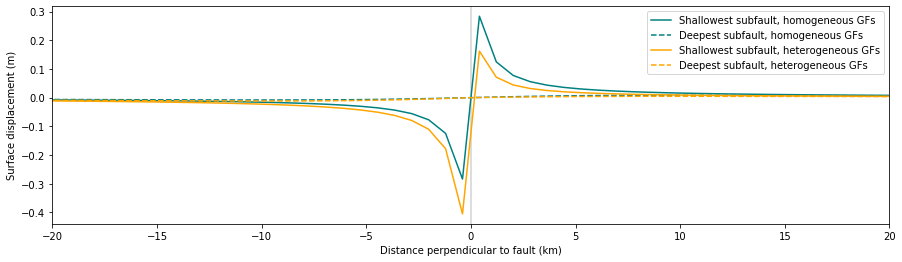

In [17]:
fig=plt.figure(figsize=(15,4))
plt.axvline(x=0,color='lightgray')
plt.plot(x/1000, Gh_ss_x3[:,0],color='teal',label='Shallowest subfault, homogeneous GFs')
plt.plot(x/1000, Gh_ss_x3[:,-1],'--',color='teal',label='Deepest subfault, homogeneous GFs')
plt.plot(x/1000, Gv_ss_x3[:,0],color='orange',label='Shallowest subfault, heterogeneous GFs')
plt.plot(x/1000, Gv_ss_x3[:,-1],'--',color='orange',label='Deepest subfault, heterogeneous GFs')
plt.xlim([-20,20])
plt.xlabel('Distance perpendicular to fault (km)')
plt.ylabel('Surface displacement (m)')
plt.legend()
plt.show()

#### 3.4 Investigate the impact of the shear moduli ratio on Green's functions

We can also investigate the impact of a variation of the shear moduli ratio ($\mu_2/\mu_1$) on the Green's functions. We calculate the Green's functions for a range of different $\mu_1$ and look at the evolution of the GFs for the shallowest and deepest subfaults:

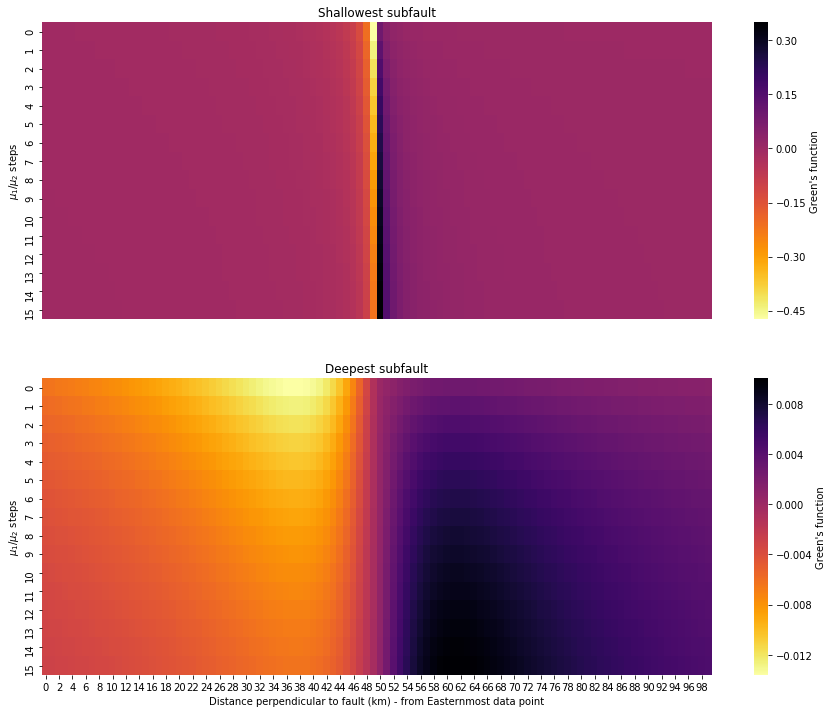

In [18]:
gfs = []
for mu_i in np.linspace(1.,8.,16.):
    gfs.append(calcGFhet(x, mu_i, mu2, width, ndip))

fig = plt.figure(figsize=(15,12))
fig.add_subplot(2,1,1)
ax = sns.heatmap(np.array(gfs)[:,:,0],cmap='inferno_r',
            linewidths=.0, rasterized=True,xticklabels=False, 
            cbar_kws={'label': 'Green\'s function'})
plt.ylabel('$\mu_1/\mu_2$ steps')
plt.title('Shallowest subfault')

fig.add_subplot(2,1,2)
ax = sns.heatmap(np.array(gfs)[:,:,-1],cmap='inferno_r',
            linewidths=.0, rasterized=True, 
            cbar_kws={'label': 'Green\'s function'})
plt.ylabel('$\mu_1/\mu_2$ steps')
plt.xlabel('Distance perpendicular to fault (km) - from Easternmost data point')
plt.title('Deepest subfault')
plt.show()

### 4. Calculate the Prediction Covariance Matrix $\mathbf{C}_\mathrm{p}$

#### 4.1 Calculate the sensitivity Kernels for $\mu_1$ and $\mu_2$

We can then derive the expressions of the sensitivity kernels of the Green's functions with respect to each shear modulus. As the shear modulus $\mu$ is a Jeffrey's parameter \citep[e.g.,][]{tarantola_2005}, the generic expression of the sensitivity kernels is:

\begin{equation}
\mathbf{K_{\mu}}(x_j, f_i) = \frac{\partial \; \mathbf{G}(x_j, f_i)}{\partial \ln  \mu} = \frac{\partial \; \mathbf{G}(x_j, f_i)}{\partial \mu} \cdot \mu.
\end{equation}	

We thus have:
\begin{equation}
\begin{split}
{}& \mathbf{K_{v, \mu_1}}^{(1)}(x_j, f_i) = - \frac{2}{\pi} \; \frac{\mu_2 \cdot \mu_1}{(\mu_1 + \mu_2)^{2}} \; \biggr[ \tan^{-1} \biggr( \frac{d_{i+1}}{x_{j}} \biggr) - \tan^{-1} \biggr( \frac{d_{i}}{x_{j}} \biggr) \biggr] \\
& \mathbf{K_{v, \mu_1}}^{(2)}(x_j, f_i) = \frac{2}{\pi} \; \frac{{\mu_1}^2}{(\mu_1 + \mu_2)^{2}} \; \biggr[ \tan^{-1} \biggr( \frac{d_{i+1}}{x_{j}} \biggr) - \tan^{-1} \biggr( \frac{d_{i}}{x_{j}} \biggr) \biggr] 
\label{vertk1}
\end{split}
\end{equation}

\begin{equation}
\begin{split}
{}& \mathbf{K_{v, \mu_2}}^{(1)}(x_j, f_i) = \frac{2}{\pi} \; \frac{{\mu_2}^2}{(\mu_1 + \mu_2)^{2}} \; \biggr[ \tan^{-1} \biggr( \frac{d_{i+1}}{x_{j}} \biggr) - \tan^{-1} \biggr( \frac{d_{i}}{x_{j}} \biggr) \biggr] \\
& \mathbf{K_{v, \mu_2}}^{(2)}(x_j, f_i) = - \frac{2}{\pi} \; \frac{{\mu_1} \cdot \mu_2 }{(\mu_1 + \mu_2)^{2}} \; \biggr[ \tan^{-1} \biggr( \frac{d_{i+1}}{x_{j}} \biggr) - \tan^{-1} \biggr( \frac{d_{i}}{x_{j}} \biggr) \biggr]
\label{vertk2}
\end{split}
\end{equation}	

In [19]:
def calcKhet(x, mu1, mu2, width, ndip):
    d = np.linspace(0.,width,ndip+1)
    Kv11 = np.zeros((len(x)//2,len(d)-1))  # 1 for mu, 1 for half space
    Kv12 = np.zeros((len(x)//2,len(d)-1))  # 1 for mu, 2 for half space
    Kv21 = np.zeros((len(x)//2,len(d)-1))  # 2 for mu, 1 for half space
    Kv22 = np.zeros((len(x)//2,len(d)-1))  # 2 for mu, 2 for half space
    # half with u1 (1)
    for j in range(len(x)//2):
        for i in range(0,len(d)-1):
            Kv11[j, i] = - (2 / np.pi) * ((mu2 * mu1) / (mu1 + mu2) ** 2) * (
                        mpmath.atan(d[i + 1] / x[j]) - mpmath.atan(d[i] / x[j]))
            Kv12[j, i] = (2 / np.pi) * ((mu1 ** 2) / (mu1 + mu2) ** 2) * (
                        mpmath.atan(d[i + 1] / x[j]) - mpmath.atan(d[i] / x[j]))
    # half with u2 (2)
    for j in range(len(x)//2,len(x)):
        for i in range(0,len(d)-1):
            Kv21[j-len(x)//2, i] = (2 / np.pi) * ((mu2**2) / (mu1 + mu2) ** 2) * (
                        mpmath.atan(d[i + 1] / x[j]) - mpmath.atan(d[i] / x[j]))
            Kv22[j-len(x)//2, i] = -  (2 / np.pi) * ((mu1 * mu2) / (mu1 + mu2) ** 2) * (
                        mpmath.atan(d[i + 1] / x[j]) - mpmath.atan(d[i] / x[j]))
    Kv1 = np.vstack((Kv11,Kv21)) # Kernel for mu1
    Kv2 = np.vstack((Kv12,Kv22)) # Kernel for mu2
    K = [Kv1]
    K.append(Kv2)
    return K

K = calcKhet(x, mu2, mu1, width, ndip)

#### 4.2 Setup the covariance of the shear moduli and the initial slip model

> *Note that here, we assume an initial model that is different from the target slip model*

In [20]:
Cov = np.diag( 0.1 * np.ones(np.shape(K)[0]))
inimodel = (s/2) * np.ones((Np//2,)) # only for the strike-slip components!

#### 4.3 Calculate $\mathbf{C}_\mathrm{\chi}$

One option when including $\mathbf{C}_\mathrm{p}$ in **AlTar** is to incorporate it directly in the misfit covariance matrix $\mathbf{C}_\mathrm{\chi}$ (see **User Guide, section Epistemic Uncertainties**). 

In [21]:
def calcCp(K,Cov,mprior):
    '''
    K : tensor of kernels
    Cov : covariance matrix (array)
    mprior : array
    '''
    k = np.transpose(np.matmul(K, mprior))
    C1 = np.matmul(k, Cov)
    Cp = np.matmul(C1, np.transpose(k))
    return Cp

Cp_x3 = calcCp(K,Cov,inimodel)

We have calculated $\mathbf{C}_\mathrm{p}$ for the $\mathbf{x}_3$ component only. The full matrix is:

In [22]:
Cp = np.block([[ np.zeros(np.shape(Cp_x3)) ,  np.zeros(np.shape(Cp_x3)), np.zeros(np.shape(Cp_x3)) ],
               [ np.zeros(np.shape(Cp_x3)) ,         Cp_x3             , np.zeros(np.shape(Cp_x3)) ],
               [ np.zeros(np.shape(Cp_x3)) ,  np.zeros(np.shape(Cp_x3)), np.zeros(np.shape(Cp_x3)) ]])

Cx = Cp + Cd

The other option is to recalculate $\mathbf{C}_\mathrm{p}$ at every step of the sampling process. In this case, AlTar needs as distinct input files: the sensitivity kernels, the covariance matrix, and the initial model.

### 5. Export input files for **AlTar**

First, we export the synthetic dataset and related uncertainties, and the homogeneous Green's functions.

In [23]:
with h5py.File(name+'.d.h5', 'w') as hf:
    hf.create_dataset('data', data=u)

with h5py.File(name+'.Cd.h5', 'w') as hf:
    hf.create_dataset('data errors', data=Cd)

with h5py.File(name+'.gf.h5', 'w') as hf:
    hf.create_dataset('GFs', data=Gh_ss)    ## in this case the only estimated parameters will be the strike-slip components

Now we can export either $\mathbf{C}_\mathrm{\chi}$ (that will replace $\mathbf{C}_\mathrm{d}$), or the other files for the second option:

In [24]:
with h5py.File(name+'.Cx.h5', 'w') as hf:
    hf.create_dataset('misfit covariance', data=Cx)

with h5py.File(name+'.KElastic.h5', 'w') as hf:
    for i in range(np.shape(K)[0]):
        hf.create_dataset('K'+str(i), data=K[i])

with h5py.File(name+'.mprior.h5', 'w') as hf:
    hf.create_dataset('mprior', data=inimodel)

with h5py.File(name+'.Cov.h5', 'w') as hf:
    hf.create_dataset('Cp covariance', data=Cov)

### 6. Create the `test1.pfg` configuration file

First, we print some values to help use fill in the `test1.pfg` file:

In [25]:
print('patches = ', Np//2)
print('observations = ', len(u))
print('GFs = ',np.shape(Gh_ss))  ## reminder: only the strike-slip components here!

## calculate moment M0 and Mw to add a prior constraint on the slip value during the sampling process.
## mu S D *20 subfaults * 10**7 to convert to dyn.cm
area = (width/ndip)*(length/nstrike)
M0 = 3.0*10**10 * 20*area * s * 10**7
Mw = (2./3.) * np.log10(M0) -10.7
print('Mw = ', Mw)
print('patches area = ', area)

patches =  20
observations =  300
GFs =  (300, 20)
Mw =  8.084060839370455
patches area =  250000000.0


The *updated $\mathbf{C}_\mathrm{p}$* option is currently only working on GPUs. Here, we thus prepare the configuration file to run **AlTar2** with:
- the *updated $\mathbf{C}_\mathrm{p}$* option
- a preparation distribution to initialize samples based on the seismic moment
- a Gaussian prior distribution centered on the target slip
- for use with GPUs

The `test1.pfg` file will thus look like (see the commented figure after for detailed explanations):

        ;
        ; (c) 2013-2019 parasim inc
        ; (c) 2010-2019 california institute of technology
        ; all rights reserved
        ;
        ; Author(s): Lijun Zhu

        ; the static uoᴉsɹǝʌuᴉ with Cp example
        slipmodel:

            model = altar.models.seismic.cuda.static
            model:

                ; the name of the test case
                case = config

                ; number of patches
                patches = 20

                ; green's function (observations, parameters)
                green = test1.gf.h5

                dataobs = altar.cuda.data.datal2
                dataobs:
                    observations = 300
                    data_file = test1.d.h5
                    cd_file = test1.cd.h5

                ; sensitivity kernels
                nCmu = 2
                cmu_file = test1.Cov.h5
                kmu_file = test1.KElastic.h5
                initial_model_file = test1.inimodel.h5

                beta_cp_start = 0.01
                beta_use_initial_model = 1

                ; list of parameterset (also used as the order parameters in theta)
                psets_list = [strikeslip]

                ; define parametersets
                psets:
                    strikeslip = altar.cuda.models.parameterset

                    strikeslip:
                        count = {slipmodel.model.patches}
                        prep = altar.models.seismic.cuda.moment
                        prep:
                            support = (0., 20.) ; slip range
                            Mw_mean = 8.08
                            Mw_sigma = 0.3
                            Mu = [30] ; in GPa
                            area = [250000000.0] ; patch area in m2
                        prior = altar.cuda.distributions.gaussian
                        prior.mean = 10.
                        prior.sigma = 3.


            controller:
                sampler = altar.cuda.bayesian.metropolis
                archiver:
                    output_dir = results/test1/ ; output directory
                    output_freq = 10 ; output frequency in beta steps

            monitors:
                ; profiling
                prof = altar.bayesian.profiler

            ; run configuration
            job.tasks = 1 ; number of tasks per host
            job.gpus = 1  ; number of gpus per task
            job.gpuprecision = float32 ; double(float64) or single(float32) precision for gpu computations
            job.gpuids = [1] ; a list gpu device ids for tasks on each host, default range(job.gpus)
            job.chains = 1000 ; number of chains per task
            job.steps = 1000 ; MC burn-in steps for each beta step

            ; shell
            shell = mpi.shells.mpirun ; for running with mpi


        ; for parallel runs
        mpi.shells.mpirun # altar.plexus.shell:
            extra = -mca btl self,tcp

        ; end of file


![Figure 2. ](commented_pfg.png)